# NLP and disaster
The main focus of this machine learning model will be to train a model to classify tweets if they are about real disasters or not.

In [1]:
#Reading in the data and importing the necessary libraries
import pandas as pd
import numpy as np

#I am stopping the warnings, forever!
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We can see 5 columns. 
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

The first thing that catches the eye is the amount of null values in the keyword and location columns. Let's see how many there are.

In [2]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [3]:
train.shape

(7613, 5)

All in all the missing values are less than 66% for every column. For text there are none. Most entries specify a keyword, and 66% specify a location.

In [4]:
#Extend the output
pd.set_option('display.max_rows',500)
#Now I am going to inspect the first 100 tweets more closely
train.text.head(100)

0     Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
5     #RockyFire Update => California Hwy. 20 closed...
6     #flood #disaster Heavy rain causes flash flood...
7     I'm on top of the hill and I can see a fire in...
8     There's an emergency evacuation happening now ...
9     I'm afraid that the tornado is coming to our a...
10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
15                                       What's up man?
16                                        I love fruits
17                                     Summer is

One of my hypotheses is that rows containing '?' are less likely to be an accident. Let's check that and engineer an extra column if possible.

In [5]:
#Filtering train for possible occurances of '?'
question_train = train[train['text'].str.contains(r'\?')]

print(train['target'].value_counts())
print(question_train['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64
0    750
1    292
Name: target, dtype: int64


We can see that the chances for disaster dramatically decrease when there is a question mark present. Hence we can engineer a column 'question'

In [6]:
#Now let's check other characters as well before removing them
#Starting with '#'
hashtag_train = train[train['text'].str.contains(r'#')]

print(train['target'].value_counts())
print(hashtag_train['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64
0    886
1    875
Name: target, dtype: int64


In [7]:
#Now let's check other characters as well before removing them
#Now '!'
exclam_train = train[train['text'].str.contains(r'\!')]

print(train['target'].value_counts())
print(exclam_train['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64
0    523
1    196
Name: target, dtype: int64


In [8]:
#Now let's check other characters as well before removing them
#'&'
and_train = train[train['text'].str.contains(r'&')]

print(train['target'].value_counts())
print(and_train['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64
0    222
1    137
Name: target, dtype: int64


In [9]:
#Now let's check other characters as well before removing them
#'@'
at_train = train[train['text'].str.contains(r'@')]

print(train['target'].value_counts())
print(at_train['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64
0    1363
1     676
Name: target, dtype: int64


In [10]:
#Now let's check other characters as well before removing them
#':'
colon_train = train[train['text'].str.contains(r':')]

print(train['target'].value_counts())
print(colon_train['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64
1    2343
0    2007
Name: target, dtype: int64


In [11]:
#Now let's check other characters as well before removing them
#'''
apostrophe_train = train[train['text'].str.contains(r"'")]

print(train['target'].value_counts())
print(apostrophe_train['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64
0    1305
1     672
Name: target, dtype: int64


In [12]:
#Now let's check other characters as well before removing them
#'"'
quote_train = train[train['text'].str.contains(r'"')]

print(train['target'].value_counts())
print(quote_train['target'].value_counts())
#This does not seem to be present
quote_train.head()

0    4342
1    3271
Name: target, dtype: int64
Series([], Name: target, dtype: int64)


,id,keyword,location,text,target


In [13]:
#Now let's check other characters as well before removing them
#'$'
dollar_train = train[train['text'].str.contains(r'\$')]

print(train['target'].value_counts())
print(dollar_train['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64
0    26
1    12
Name: target, dtype: int64


In [14]:
#Now let's check other characters as well before removing them
#'`'
backtick_train = train[train['text'].str.contains(r'`')]

print(train['target'].value_counts())
print(backtick_train['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64
1    2
0    1
Name: target, dtype: int64


### Useful signs
For our analysis, the appearance of the following punctuation marks are good predictors. 
?, !, &, @, :, '

I'll create columns for them

In [15]:
#This will be in a function to transform test later
train['question'] = train['text'].str.contains(r'\?')
train['exclam'] = train['text'].str.contains(r'!')
train['and_sign'] = train['text'].str.contains(r'&')
train['at'] = train['text'].str.contains(r'@')
train['colon'] = train['text'].str.contains(r':')
train['apostrophe'] = train['text'].str.contains(r"'")

## A case case
Before we convert everything to lowercase it might be smart to see whether lowercase and uppercase characters are good at predicting the outcome. Therefore we will have to count the ratio's of uppercase to lowercase first. From there we can find out if someone is using caps lock or not. Or if tweets with generally more uppercase letters have a bigger chance predicting if a tweet is about a real accident. 

In [16]:
train['lower'] = train['text'].apply(lambda x: sum(map(str.islower, x)))
train['lower'].head()

0     46
1     26
2    107
3     49
4     67
Name: lower, dtype: int64

In [17]:
train['upper'] = train['text'].apply(lambda x: sum(map(str.isupper, x)))
train['upper'].head()

0    10
1     5
2     2
3     1
4     3
Name: upper, dtype: int64

In [18]:
train['upper_vs_lower'] = train['upper'] - train['lower']

In [19]:
train['upper_vs_lower'].value_counts()

-52     111
-75     111
-60     110
-67     110
-66     108
-48     105
-65     105
-79     104
-46     104
-51     103
-61     103
-50     102
-71     102
-54     102
-56     101
-84     100
-69      98
-74      98
-72      98
-35      97
-88      97
-58      96
-80      96
-64      96
-89      95
-76      94
-68      94
-78      93
-73      91
-37      90
-39      90
-49      88
-53      88
-82      88
-86      88
-81      87
-38      86
-44      86
-42      85
-85      85
-83      85
-40      85
-33      85
-59      84
-63      83
-45      83
-91      83
-57      83
-36      83
-62      82
-41      81
-70      81
-77      81
-29      81
-55      80
-47      79
-87      79
-92      76
-43      76
-34      75
-93      75
-28      72
-32      69
-99      68
-95      68
-30      67
-100     61
-98      61
-27      59
-101     58
-90      57
-94      56
-26      55
-31      55
-96      51
-97      50
-24      50
-25      47
-23      46
-19      44
-21      41
-18      38
-20      37
-104

### The case problem case
The problem here becomes what to decide, when does the case matter and when doesn't it. Should we draw the line at e.g. 10% uppercase letters per tweet, or should we really take a look at caps. Let's find out where to draw the line best!

In [20]:
#we'll see if there is a big difference in predictions where there are more uppercase than lowercase characters.
caps_train = train[train['upper_vs_lower'] > 0]
caps_train['target'].value_counts()

0    154
1     67
Name: target, dtype: int64

[141, 221, 297, 586, 1105, 1902]


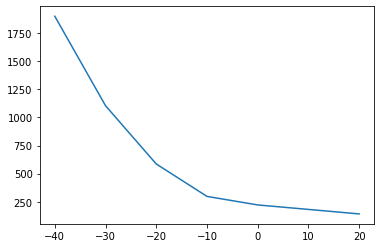

In [21]:
#We can see the chances decrease for many uppercase letters. 
#Let's test which value would be the best for estimating the probablity.
import matplotlib.pyplot as plt
def sum_caps(x):
    caps = train[train['upper_vs_lower'] > x]
    return caps['target'].shape[0]
    
vals = [20,0,-10,-20,-30,-40]

sums = [sum_caps(i) for i in vals]
plt.plot(vals,sums)
print(sums)

[0.3475177304964539, 0.3031674208144796, 0.2760942760942761, 0.2508532423208191, 0.27601809954751133, 0.3322818086225026]


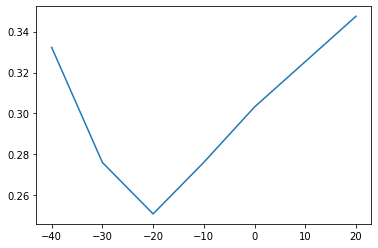

In [22]:
def p_caps(x):
    caps = train[train['upper_vs_lower'] > x]
    return caps['target'].sum() / caps.shape[0]
    
vals = [20,0,-10,-20,-30,-40]

p_sums = [p_caps(i) for i in vals]
plt.plot(vals,p_sums)
print(p_sums)

We can clearly see that the best chances are acquired when we select the upper column to be on -30. Despite the fact that it might not be the lowest value, still the chances for predicting the right value are increased for 300 entries!

In [23]:
train['upper_lower'] = train['upper_vs_lower'] > -30

[0.438173142467621, 0.5116477879888865, 0.4988888888888889, 0.45317220543806647, 0.4009009009009009, 0.37844611528822053, 0.3897058823529412, 0.40404040404040403, 0.3987730061349693]


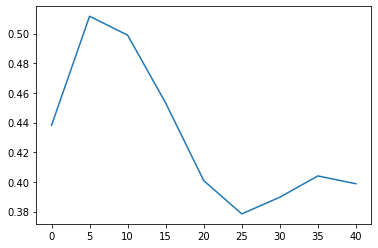

In [24]:
#The other thing left to check is if the amount of uppercase characters matters
def amount_upper(x):
    upper = train[train['upper'] > x]
    return upper['target'].sum() / upper.shape[0]
    
vals_upper = [0,5,10,15,20,25,30,35,40]

upper_sums = [amount_upper(i) for i in vals_upper]
plt.plot(vals_upper,upper_sums)
print(upper_sums)

### Case closed
As we can see the probabilities of predicting right with the amount of uppercase letters does not matter that much. So we can discard this as a feature. We will keep the upper_lower column, drop the others and go on. 

In [25]:
train = train.drop(['upper','lower','upper_vs_lower'],axis=1)

In [26]:
#Let's see for fun what the accuracy is for these punctuation marks
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

punc_cols = ['question','exclam','and_sign','at','colon','apostrophe','upper_lower']

#converting the boolean columns to binary
train[punc_cols] = train[punc_cols].astype(int)

kf = KFold(n_splits=5)
acc_scores = []
for train_index, test_index in kf.split(train):
    training = train.loc[train_index]
    testing = train.loc[test_index]
    
    model = LogisticRegression()
    model.fit(training[punc_cols],training['target'])
    
    predictions = model.predict(testing[punc_cols])
    acc = accuracy_score(testing['target'],predictions)
    acc_scores.append(acc)

print(acc_scores)
print(sum(acc_scores)/len(acc_scores))

[0.6638214051214708, 0.6454366382140512, 0.6460932370321734, 0.6767411300919842, 0.6787122207621551]
0.662160926244367


### Results
For our punctuation columns the accuracy score is 66% not bad, considering that we have not read a single letter yet!

### More features!

In [71]:
#The feature engineering has actually made a difference. Therefore I will try to find more features!

#The length of the tweets is probably a good one.
train['length'] = train['text'].apply(len)

def standardize(df, label):
    """
    standardizes a series with name ``label'' within the pd.DataFrame
    ``df''.
    """
    df = df.copy(deep=True)
    series = df.loc[:, label]
    avg = series.mean()
    stdv = series.std()
    series_standardized = (series - avg)/ stdv
    return series_standardized
    
train['length'] = standardize(train,'length')
train['length'].head(50)

0    -0.428438
1    -1.424268
2     1.563222
3    -0.749673
4     0.149786
5     0.631639
6     0.342527
7    -0.846044
8    -0.107202
9    -1.070909
10   -1.231527
11    1.466852
12   -0.524808
13   -1.424268
14   -0.910291
15   -2.227357
16   -2.195233
17   -2.098862
18   -2.066739
19   -1.906121
20   -2.034615
21   -2.130986
22   -2.259480
23   -1.970368
24   -2.355851
25   -1.777627
26   -1.970368
27   -2.034615
28   -2.387974
29   -2.066739
30   -2.387974
31   -1.584886
32   -1.263650
33   -0.813920
34   -1.552762
35   -0.878167
36    1.177740
37   -1.584886
38    1.017122
39   -1.938245
40   -1.841874
41   -0.749673
42    1.145616
43   -1.360021
44   -0.492685
45   -0.332067
46   -0.235696
47   -0.589056
48   -1.841874
49    1.659593
Name: length, dtype: float64

In [28]:
#We can also take a look at the chances for the locations and keywords.
train['location'].value_counts()

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
Somewhere Around You            1
Elmwood Park, NJ                1
Amsterdam                       1
White Plains, NY                1
The Orwellion police-state      1
Name: location, Length: 3341, dtype: int64

In [29]:
train['location'].head(100)

0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
5                               NaN
6                               NaN
7                               NaN
8                               NaN
9                               NaN
10                              NaN
11                              NaN
12                              NaN
13                              NaN
14                              NaN
15                              NaN
16                              NaN
17                              NaN
18                              NaN
19                              NaN
20                              NaN
21                              NaN
22                              NaN
23                              NaN
24                              NaN
25                              NaN
26                              NaN
27                          

In [30]:
#The location column needs some cleaning.
#Keeping things easy, if the column contain a comma it's likely to be an english country. 
train['location'] = train['location'].fillna('U')
train.loc[train['location'].str.contains(','), 'location'] = 'E'
train['location'] = train['location'].str.replace('USA','E', case=False).str.replace('United States', 'E', case=False).str.replace('Canada','E',case=False).str.replace('New York','E', case=False).str.replace('London', 'E',case=False).str.replace('Australia','E',case=False).str.replace('UK','E',case=False)

#Now to sum up our very rough cleaning of the location we will make all the others 'o'
train['location'] = train['location'].where((train['location']=='U') | (train['location'] == 'E'),'O')
train['location'].value_counts()

O    2870
U    2533
E    2210
Name: location, dtype: int64

In [49]:
train.loc[train['location']=='O','target'].value_counts()

0    1679
1    1191
Name: target, dtype: int64

In [51]:
train.loc[train['location']=='U','target'].value_counts()

0    1458
1    1075
Name: target, dtype: int64

In [53]:
train.loc[train['location']=='E','target'].value_counts()

0    1205
1    1005
Name: target, dtype: int64

All in all our rough location indexes might help a bit in the end. Especially for U and O the chances for being a real disaster decrease. 

### Keyword analysis

In [62]:
print(train['keyword'].value_counts(dropna=False))
train['keyword'].value_counts(dropna=False).shape[0]

unknown                  61
fatalities               45
deluge                   42
armageddon               42
harm                     41
damage                   41
sinking                  41
body%20bags              41
collided                 40
windstorm                40
twister                  40
evacuate                 40
siren                    40
fear                     40
outbreak                 40
hellfire                 39
whirlwind                39
weapon                   39
weapons                  39
collision                39
derailment               39
earthquake               39
sunk                     39
wrecked                  39
wreckage                 39
sinkhole                 39
flames                   39
famine                   39
explosion                39
hurricane                38
explode                  38
injury                   38
thunder                  38
upheaval                 38
blaze                    38
flooding            

222

In [59]:
train['keyword'].fillna('unknown',inplace=True)

In [72]:
#We can use the keywords to do one hot encoding, aka creating dummy columns. 
#This is the last step here so we will sum up all the other measures for test.
def test_keyword_location(train):
    train['length'] = train['text'].apply(len).std()
    train['length'] = standardize(train,'length')
    train['location'] = train['location'].fillna('U')
    train.loc[train['location'].str.contains(','), 'location'] = 'E'
    train['location'] = train['location'].str.replace('USA','E', case=False).str.replace('United States', 'E', case=False).str.replace('Canada','E',case=False).str.replace('New York','E', case=False).str.replace('London', 'E',case=False).str.replace('Australia','E',case=False).str.replace('UK','E',case=False)
    train['location'] = train['location'].where((train['location']=='U') | (train['location'] == 'E'),'O')
    train['keyword'].fillna('unknown',inplace=True)
    return train

test = test_keyword_location(test)
  
#After the creation of the tfidf matrix we can add these!
keyword_train_dummies = pd.get_dummies(train['keyword'],prefix='keyword')
keyword_test_dummies = pd.get_dummies(test['keyword'],prefix='keyword')
location_train_dummies = pd.get_dummies(train['location'],prefix='location')
location_test_dummies = pd.get_dummies(test['location'],prefix='location')

In [31]:
#This function will pre-transform test when the time is right.
def pre_transform_features(train):
    train['question'] = train['text'].str.contains(r'\?')
    train['exclam'] = train['text'].str.contains(r'!')
    train['and_sign'] = train['text'].str.contains(r'&')
    train['at'] = train['text'].str.contains(r'@')
    train['colon'] = train['text'].str.contains(r':')
    train['apostrophe'] = train['text'].str.contains(r"'")
    
    train['lower'] = train['text'].apply(lambda x: sum(map(str.islower, x)))
    train['upper'] = train['text'].apply(lambda x: sum(map(str.isupper, x)))
    train['upper_vs_lower'] = train['upper'] - train['lower']
    train['upper_lower'] = train['upper_vs_lower'] > -30
    
    train = train.drop(['upper','lower','upper_vs_lower'],axis=1)
    return train

test = pre_transform_features(test)

## Transformations 
after summing up the pre-transformation cleaning in a function to perform later, we will go on with transforming the text to lowercase, and use the following methods to train the model:

- *bag of words-method* 
- *TF-IDF* which means that words get a penalty for being in the document too frequently.

In order to get a great quality tokenized vector we need to do the following things:
* transform everything to lowercase, and remove punctuation.
* remove the most used words (stopwords) in English that are not useful for our analysis.
* populate one column per unique word with count or TF-IDF.

Fortunately we have ScikitLearn utilities to do most of this. 

In [32]:
import re
import string

#This is a function to remove punctuation, links, html etc.
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [33]:
import nltk
from nltk.corpus import stopwords
sw = stopwords.words("english")
print(sw[:5])

['i', 'me', 'my', 'myself', 'we']


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#inside the CountVectorizet instance we can specify stopwords, the minimum amount for a word to appear and the maximum.
#the maximum is given as a proportion to the whole document
cvec = CountVectorizer(stop_words = sw, min_df=2, max_df = 0.8)
cvec.fit(train['text'])

#Vectorizing the text
train_cvec = cvec.transform(train['text'])
test_cvec = cvec.transform(test['text'])

#We can see that the output is a spars numpy array, which has deleted the zeros to save RAM.
#This is effectively the bag of words!
test_cvec[:5]

<5x6117 sparse matrix of type '<class 'numpy.int64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [35]:
#Now we can also create a tfidf matrix.
tfidf = TfidfVectorizer(stop_words=sw, min_df=2, max_df= 0.8)
tfidf.fit(train['text'])

train_tfidf = tfidf.transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

test_tfidf[:5]

<5x6117 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

## Model training

We can now train a few models and cross_validate to see which is performing best. As an error metric I will use the [f1 score](https://en.wikipedia.org/wiki/Precision_and_recall), Which is the weighted average of the precision(accuracy) and recall scores. For now I will train the following models:

- good old Logistic regression
- Multinominal Naive Bayes
- Bernoulli Naive Bayes, which sometimes just works better

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

lr = LogisticRegression()
mnb = MultinomialNB()
bnb = BernoulliNB()

#I've added this one later, but it scores poorly.
svc = SVC()

models = [lr,mnb,bnb]

#testing the CountVectorized data first
for model in models:
    cv_scores = cross_val_score(model, train_cvec, train['target'], cv=5, scoring='f1')
    print(cv_scores)
    print(sum(cv_scores) / len(cv_scores))

[0.60018815 0.49574106 0.56716418 0.53544776 0.6921875 ]
0.5781457286542068
[0.62940671 0.59865972 0.68592593 0.63788969 0.7348643 ]
0.6573492677291572
[0.63100635 0.60254372 0.67405063 0.63212435 0.74686347]
0.657317704079332


In [37]:
#Now the turn for tfidf
for model in models:
    cv_scores = cross_val_score(model, train_tfidf, train['target'], cv=5, scoring='f1')
    print(cv_scores)
    print(sum(cv_scores) / len(cv_scores))

[0.59545005 0.51179673 0.55229358 0.53121903 0.67361111]
0.5728741001004832
[0.61075661 0.60392799 0.66287571 0.61444735 0.74581431]
0.6475643919240748
[0.63100635 0.60254372 0.67405063 0.63212435 0.74686347]
0.657317704079332


### Model evaluation
As we can see, the top entries are very similar in score. Let's see if we can tweak this score slightly by adding our punctuation columns. 

It should be noted that the f1 score is often lower than the accuracy score. Let's quickly confirm this.

In [38]:
#Now the turn for tfidf
for model in models:
    cv_scores = cross_val_score(model, train_tfidf, train['target'], cv=5, scoring='accuracy')
    print(cv_scores)
    print(sum(cv_scores) / len(cv_scores))

[0.73145108 0.64674984 0.67957978 0.6892247  0.75295664]
0.6999924072672805
[0.7196323  0.68220617 0.72751149 0.70893561 0.78055191]
0.723767496719163
[0.73276428 0.67170059 0.72948129 0.72010512 0.77463863]
0.7257379834219584


In [39]:
#We can make a submission to kaggle now using the Bernoulli Naive Bayes version.
def make_prediction(model, vectorized_train, target, vectorized_test):
    model.fit(vectorized_train, target)
    predictions = model.predict(vectorized_test)
    return predictions

def save_submission(predictions,test,filename):
    end = pd.DataFrame()
    end['id'] = test['id']
    end['target'] = predictions
    end.to_csv(filename,index=False)

In [40]:
predict_bnb_tfidf = make_prediction(bnb, train_tfidf, train['target'], test_tfidf)
filename = 'bnb_tfidf.csv'
save_submission(predict_bnb_tfidf,test,filename)
#The score for this submission was 0.79282, which is around the 55th percentile.

In [41]:
#Now we can add the punctuation columns to see what happens!
#In order to do that we need to transform the train_cvec and test_cvec from sparse to dense matrix (adding the zeros)

dense_train_cvec = train_cvec.todense()
total_train_cvec = np.append(dense_train_cvec, train[punc_cols],1)

dense_test_cvec = test_cvec.todense()
total_test_cvec = np.append(dense_test_cvec, test[punc_cols],1)

In [42]:
total_train_cvec[:5]

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [43]:
#Now we can train our models again see if there is any difference.
for model in models:
    cv_scores = cross_val_score(model, total_train_cvec, train['target'], cv=5, scoring='f1')
    print(cv_scores)
    print(sum(cv_scores) / len(cv_scores))

[0.6027907  0.52718287 0.5982215  0.60436681 0.70652174]
0.6078167238453196
[0.64223386 0.61526946 0.68346924 0.63382594 0.75213675]
0.6653870501500743
[0.64120782 0.60577674 0.69177556 0.63220339 0.75558867]
0.6653104345830402


In [44]:
dense_train_tfidf = train_tfidf.todense()
total_train_tfidf = np.append(dense_train_tfidf, train[punc_cols],1)

dense_test_tfidf = test_tfidf.todense()
total_test_tfidf = np.append(dense_test_tfidf, test[punc_cols],1)

In [45]:
#Now the turn for tfidf
for model in models:
    cv_scores = cross_val_score(model, total_train_tfidf, train['target'], cv=5, scoring='f1')
    print(cv_scores)
    print(sum(cv_scores) / len(cv_scores))

[0.62126866 0.58091993 0.62975207 0.61621622 0.72391653]
0.6344146807621065
[0.62734584 0.60227273 0.67447307 0.64915254 0.74713522]
0.6600758799577549
[0.64120782 0.60577674 0.69177556 0.63220339 0.75558867]
0.6653104345830402


As seen there is a huge increase for the logistic regression, and the others are actually improving 0.01 as well time for a second submission! :D

In [46]:
predict_bnb_tfidf_punc = make_prediction(bnb, total_train_tfidf, train['target'], total_test_tfidf)
filename = 'bnb_punc_tfidf.csv'
save_submission(predict_bnb_tfidf_punc,test,filename)
#0.79221, which is not better than the first one :(

In [47]:
predict_lr_tfidf_punc = make_prediction(lr, total_train_tfidf, train['target'], total_test_tfidf)
filename = 'lr_punc_tfidf.csv'
save_submission(predict_lr_tfidf_punc,test,filename)
#0.79834 which is my best up to now. Very strange considering it scored 0.03 lower in the test set!

In [74]:
#Now we can append the new dummy columns made above to the np.array
complete_train_tfidf = np.append(total_train_tfidf, keyword_train_dummies, 1)
complete_train_tfidf = np.append(complete_train_tfidf, location_train_dummies, 1)

complete_test_tfidf = np.append(total_test_tfidf, keyword_test_dummies, 1)
complete_test_tfidf = np.append(complete_test_tfidf, location_test_dummies, 1)

In [75]:
#It was clear that tfidf worked better
for model in models:
    cv_scores = cross_val_score(model, complete_train_tfidf, train['target'], cv=5, scoring='f1')
    print(cv_scores)
    print(sum(cv_scores) / len(cv_scores))

[0.53307009 0.43189369 0.54913728 0.53641208 0.64592593]
0.539287812990483
[0.55166217 0.47982063 0.60503059 0.59762846 0.69143995]
0.5851163597906393
[0.60477454 0.54707191 0.64367816 0.62980769 0.71349096]
0.6277646507634709


In [76]:
#Despite the bad scores, let's predict anyway
predict_bnb_tfidf_complete = make_prediction(bnb, complete_train_tfidf, train['target'], complete_test_tfidf)
filename = 'bnb_complete_tfidf.csv'
save_submission(predict_bnb_tfidf_complete,test,filename)
#0.79344 second best, still not bad, considering the cross val scores were so awful. Maybe lr will even do better.

In [77]:
#A case for Lr?
predict_lr_tfidf_complete = make_prediction(lr, complete_train_tfidf, train['target'], complete_test_tfidf)
filename = 'lr_complete_tfidf.csv'
save_submission(predict_lr_tfidf_complete,test,filename)
#0.79221 still not bad, but it seems hard to improve. 

This is it for now. I've had my fun, learned a lot about NLP and see you next time! The main takeaway is that the most influential parts are the text and the punctuation. Location and keyword are less important. 